In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats.mstats import winsorize
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn import ensemble
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz
from sklearn.metrics import plot_confusion_matrix

For this project, I will be analyzing data from reviews of Rent the Runway (available [here](https://www.kaggle.com/rmisra/clothing-fit-dataset-for-size-recommendation)). Rent the Runway is a clothing rental service that allows users to rent items of clothing. I will begin by looking at the first few rows of data, datatypes of each variable, and percentage of missing data.

In [2]:
#load data and look at first few rows
rtr_df = pd.read_json('renttherunway_final_data.json', lines = True)
rtr_df. head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"


In [3]:
#get datatypes
rtr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 15 columns):
fit               192544 non-null object
user_id           192544 non-null int64
bust size         174133 non-null object
item_id           192544 non-null int64
weight            162562 non-null object
rating            192462 non-null float64
rented for        192534 non-null object
review_text       192544 non-null object
body type         177907 non-null object
review_summary    192544 non-null object
category          192544 non-null object
height            191867 non-null object
size              192544 non-null int64
age               191584 non-null float64
review_date       192544 non-null object
dtypes: float64(2), int64(3), object(10)
memory usage: 22.0+ MB


In [4]:
#check for missing data
rtr_df.isnull().sum()*100/rtr_df.isnull().count()

fit                0.000000
user_id            0.000000
bust size          9.561970
item_id            0.000000
weight            15.571506
rating             0.042588
rented for         0.005194
review_text        0.000000
body type          7.601899
review_summary     0.000000
category           0.000000
height             0.351608
size               0.000000
age                0.498587
review_date        0.000000
dtype: float64

Each row in the data set represents one rental. I noticed that some of the variables that we would expect to be numeric were object-type variables, specifically height and weight. When I looked at the percentage of missing variables, all of the variables were missing values for less than 10 percent of the data with the exception of weight. It is possible that people with higher weights may be less likely to enter their weight, so we may skew our data by simply dropping this data.

In [5]:
#convert weight to float
rtr_df['weight'] = rtr_df['weight'].str.replace('lbs', '')
rtr_df['weight'] = rtr_df['weight'].apply(lambda x: float(x))

In [6]:
#select rows where weight is missing
missing_weight = rtr_df[rtr_df['weight'].isnull()]

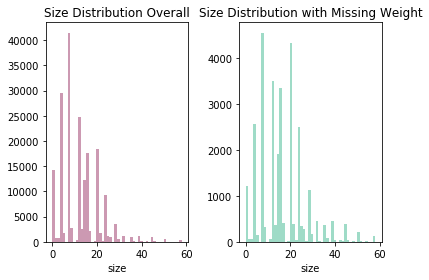

In [7]:
#plot size distribution where weight is missing and overall
plt.subplot(1, 2, 1)
sns.distplot(rtr_df['size'], kde = False, color = '#80013f')
plt.title('Size Distribution Overall')
plt.subplot(1, 2, 2)
sns.distplot(missing_weight['size'], kde = False, color = '#10a674')
plt.title('Size Distribution with Missing Weight')
plt.tight_layout()
plt.show()

We can see from the two histograms above that the size distribution of the missing weights is shifted to the right, i.e., that more people who wore a larger size (likely indicating a greater weight) were less likely to include their weight in their feedback. Based on the assumption that people who wear the same size are likely to be within a similar weight range, we will replace the missing values with the mean weight by size.

In [8]:
#replace missing weight with average weight by size
rtr_df['weight'] = rtr_df.groupby('size')['weight'].transform(lambda x: x.fillna(x.mean()))

Because each of the other variables are missing less than 10 percent of the data, we will go ahead and drop the missing values for the rest of the variables.

In [9]:
#drop missing values
rtr_df = rtr_df.dropna()

Because height was entered in feet and inches, it is an object type variable. We will transform the variable into height in inches so that it can be converted into a numeric variable.

In [10]:
#convert height to inches
def convert_height(ht):
    # format: 7' 0"
    ht = ht.split("' ")
    ft = float(ht[0])
    inch = float(ht[1].replace("\"",""))
    return (12*ft) + inch

rtr_df['height'] = rtr_df['height'].apply(lambda x:convert_height(x))

Next, we will look at the distributions of the numeric variables.

In [11]:
#get variable distributions
rtr_df.describe()

,user_id,item_id,weight,rating,height,size,age
count,164684.000000,1.646840e+05,164684.000000,164684.000000,164684.000000,164684.000000,164684.000000
mean,499476.359112,1.038580e+06,138.614481,9.080858,65.296058,12.033962,33.968394
std,288979.825038,8.093484e+05,22.095767,1.437587,2.666378,8.217566,8.050099
min,9.000000,1.233730e+05,50.000000,2.000000,54.000000,0.000000,0.000000
25%,250760.500000,1.878572e+05,125.000000,8.000000,63.000000,7.000000,29.000000
50%,499273.500000,9.376380e+05,135.000000,10.000000,65.000000,12.000000,32.000000
75%,751032.000000,1.676837e+06,150.000000,10.000000,67.000000,16.000000,37.000000
max,999997.000000,2.966087e+06,300.000000,10.000000,78.000000,58.000000,117.000000


When looking at these values, we can see a few anomalies. The minimum value for weight is 50, which seems low unless a child is renting this clothing. Size ranges from 0 to 58, which indicates that multiple sizing methods may be used within the RTR collection. Age ranges from 0 to 117, which does not seem accurate on either side of the spectrum. It is possible that people were inputting nonsense values rather than their actual ages.

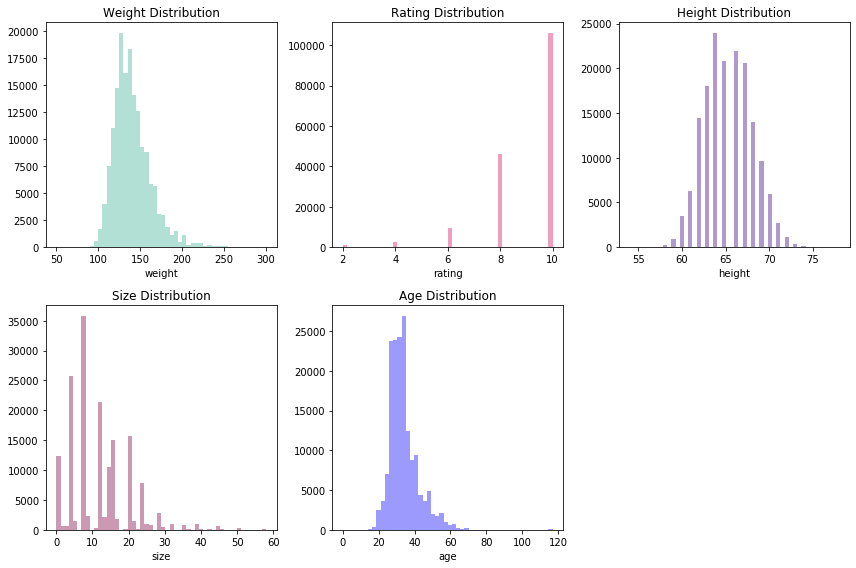

In [12]:
#plot distributions of numeric variables
plt.figure(figsize = (12, 8))
plt.subplot(2, 3, 1)
sns.distplot(rtr_df['weight'], kde = False, color = '#42b395')
plt.title('Weight Distribution')
plt.subplot(2, 3, 2)
sns.distplot(rtr_df['rating'], kde = False, color = '#de0c62')
plt.title('Rating Distribution')
plt.subplot(2, 3, 3)
sns.distplot(rtr_df['height'], kde = False, color = '#380282')
plt.title('Height Distribution')
plt.subplot(2, 3, 4)
sns.distplot(rtr_df['size'], kde = False, color = '#80013f')
plt.title('Size Distribution')
plt.subplot(2, 3, 5)
sns.distplot(rtr_df['age'], kde = False, color = '#0804f9')
plt.title('Age Distribution')
plt.tight_layout()
plt.show()

From the histograms of each of the variables, we can see that there are very few values at the tails of the weight distribution, the height distribution, and the age distribution. The ratings distribution is shifter to the right; more people gave higher ratings than lower ratings. The size distribution is shifted to the left; this is likely because most of the items that RTR rents are sized based on a system starting at 0. Because age and weight have some anomalous values, we are going to winsorize the data to replace some of these values.

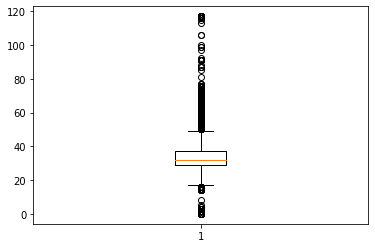

In [13]:
#visualize outliers on boxplot
plt.boxplot(rtr_df['age'])
plt.show()

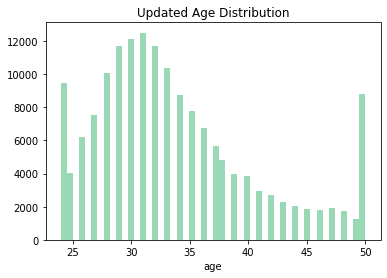

In [14]:
#winsorize the age data on both sides
rtr_df['age'] = winsorize(rtr_df['age'], (0.05, 0.05))
sns.distplot(rtr_df['age'], kde = False, color = '#01a049')
plt.title('Updated Age Distribution')
plt.show()

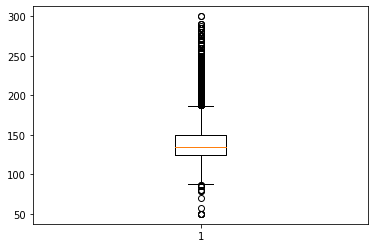

In [15]:
#visualize outliers for weight on boxplot
plt.boxplot(rtr_df['weight'])
plt.show()

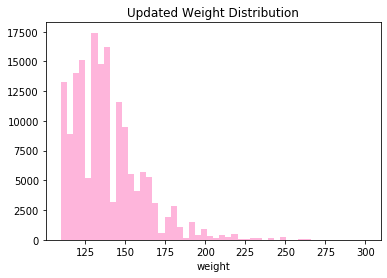

In [16]:
#winsorize lower end of weight distribution
rtr_df['weight'] = winsorize(rtr_df['weight'], (0.05, 0))
sns.distplot(rtr_df['weight'], kde = False, color = '#fe46a5')
plt.title('Updated Weight Distribution')
plt.show()

In [17]:
#check updated summary statistics
rtr_df.describe()

,user_id,item_id,weight,rating,height,size,age
count,164684.000000,1.646840e+05,164684.000000,164684.000000,164684.000000,164684.000000,164684.000000
mean,499476.359112,1.038580e+06,138.860638,9.080858,65.296058,12.033962,33.766091
std,288979.825038,8.093484e+05,21.720699,1.437587,2.666378,8.217566,6.898708
min,9.000000,1.233730e+05,110.000000,2.000000,54.000000,0.000000,24.000000
25%,250760.500000,1.878572e+05,125.000000,8.000000,63.000000,7.000000,29.000000
50%,499273.500000,9.376380e+05,135.000000,10.000000,65.000000,12.000000,32.000000
75%,751032.000000,1.676837e+06,150.000000,10.000000,67.000000,16.000000,37.000000
max,999997.000000,2.966087e+06,300.000000,10.000000,78.000000,58.000000,50.000000


Next, I want to define a new variable called perfect rating that is true if the rental is rated a 10.0, and false otherwise. I will use this variable in a classification model to classify whether rentals are rated 10.0 or not.

In [18]:
#define perfect rating variable
rtr_df['perfect_rating'] = rtr_df['rating'] == 10

In [19]:
#get percentage of ratings equal to 10
print('Perfect ratings: ', len(rtr_df[rtr_df['perfect_rating']== True])/len(rtr_df))
print('Ratings less than 10.0: ', len(rtr_df[rtr_df['perfect_rating']== False])/len(rtr_df))

Perfect ratings:  0.6432804644045566
Ratings less than 10.0:  0.3567195355954434


64% of ratings receive perfect ratings. Next, I will look at the correlation between variables.

In [20]:
#get correlation between variables
rtr_df.corr()

,user_id,item_id,weight,rating,height,size,age,perfect_rating
user_id,1.000000,-0.004132,0.006352,-0.007809,-0.009472,0.006914,0.013208,-0.008428
item_id,-0.004132,1.000000,-0.045611,0.000097,0.005596,-0.040404,0.030764,0.008788
weight,0.006352,-0.045611,1.000000,-0.026029,0.359250,0.872661,0.068041,-0.030536
rating,-0.007809,0.000097,-0.026029,1.000000,0.001321,-0.037243,-0.034616,0.858591
height,-0.009472,0.005596,0.359250,0.001321,1.000000,0.236816,-0.001305,0.002202
size,0.006914,-0.040404,0.872661,-0.037243,0.236816,1.000000,0.157429,-0.041948
age,0.013208,0.030764,0.068041,-0.034616,-0.001305,0.157429,1.000000,-0.025330
perfect_rating,-0.008428,0.008788,-0.030536,0.858591,0.002202,-0.041948,-0.025330,1.000000


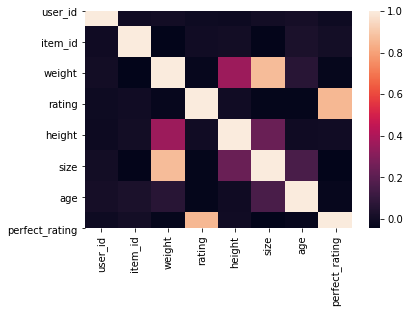

In [21]:
#show heatmap of variables
sns.heatmap(rtr_df.corr())
plt.show()

Next, I will look at the average rating by fit, bust size, rented for, category, and body type. 

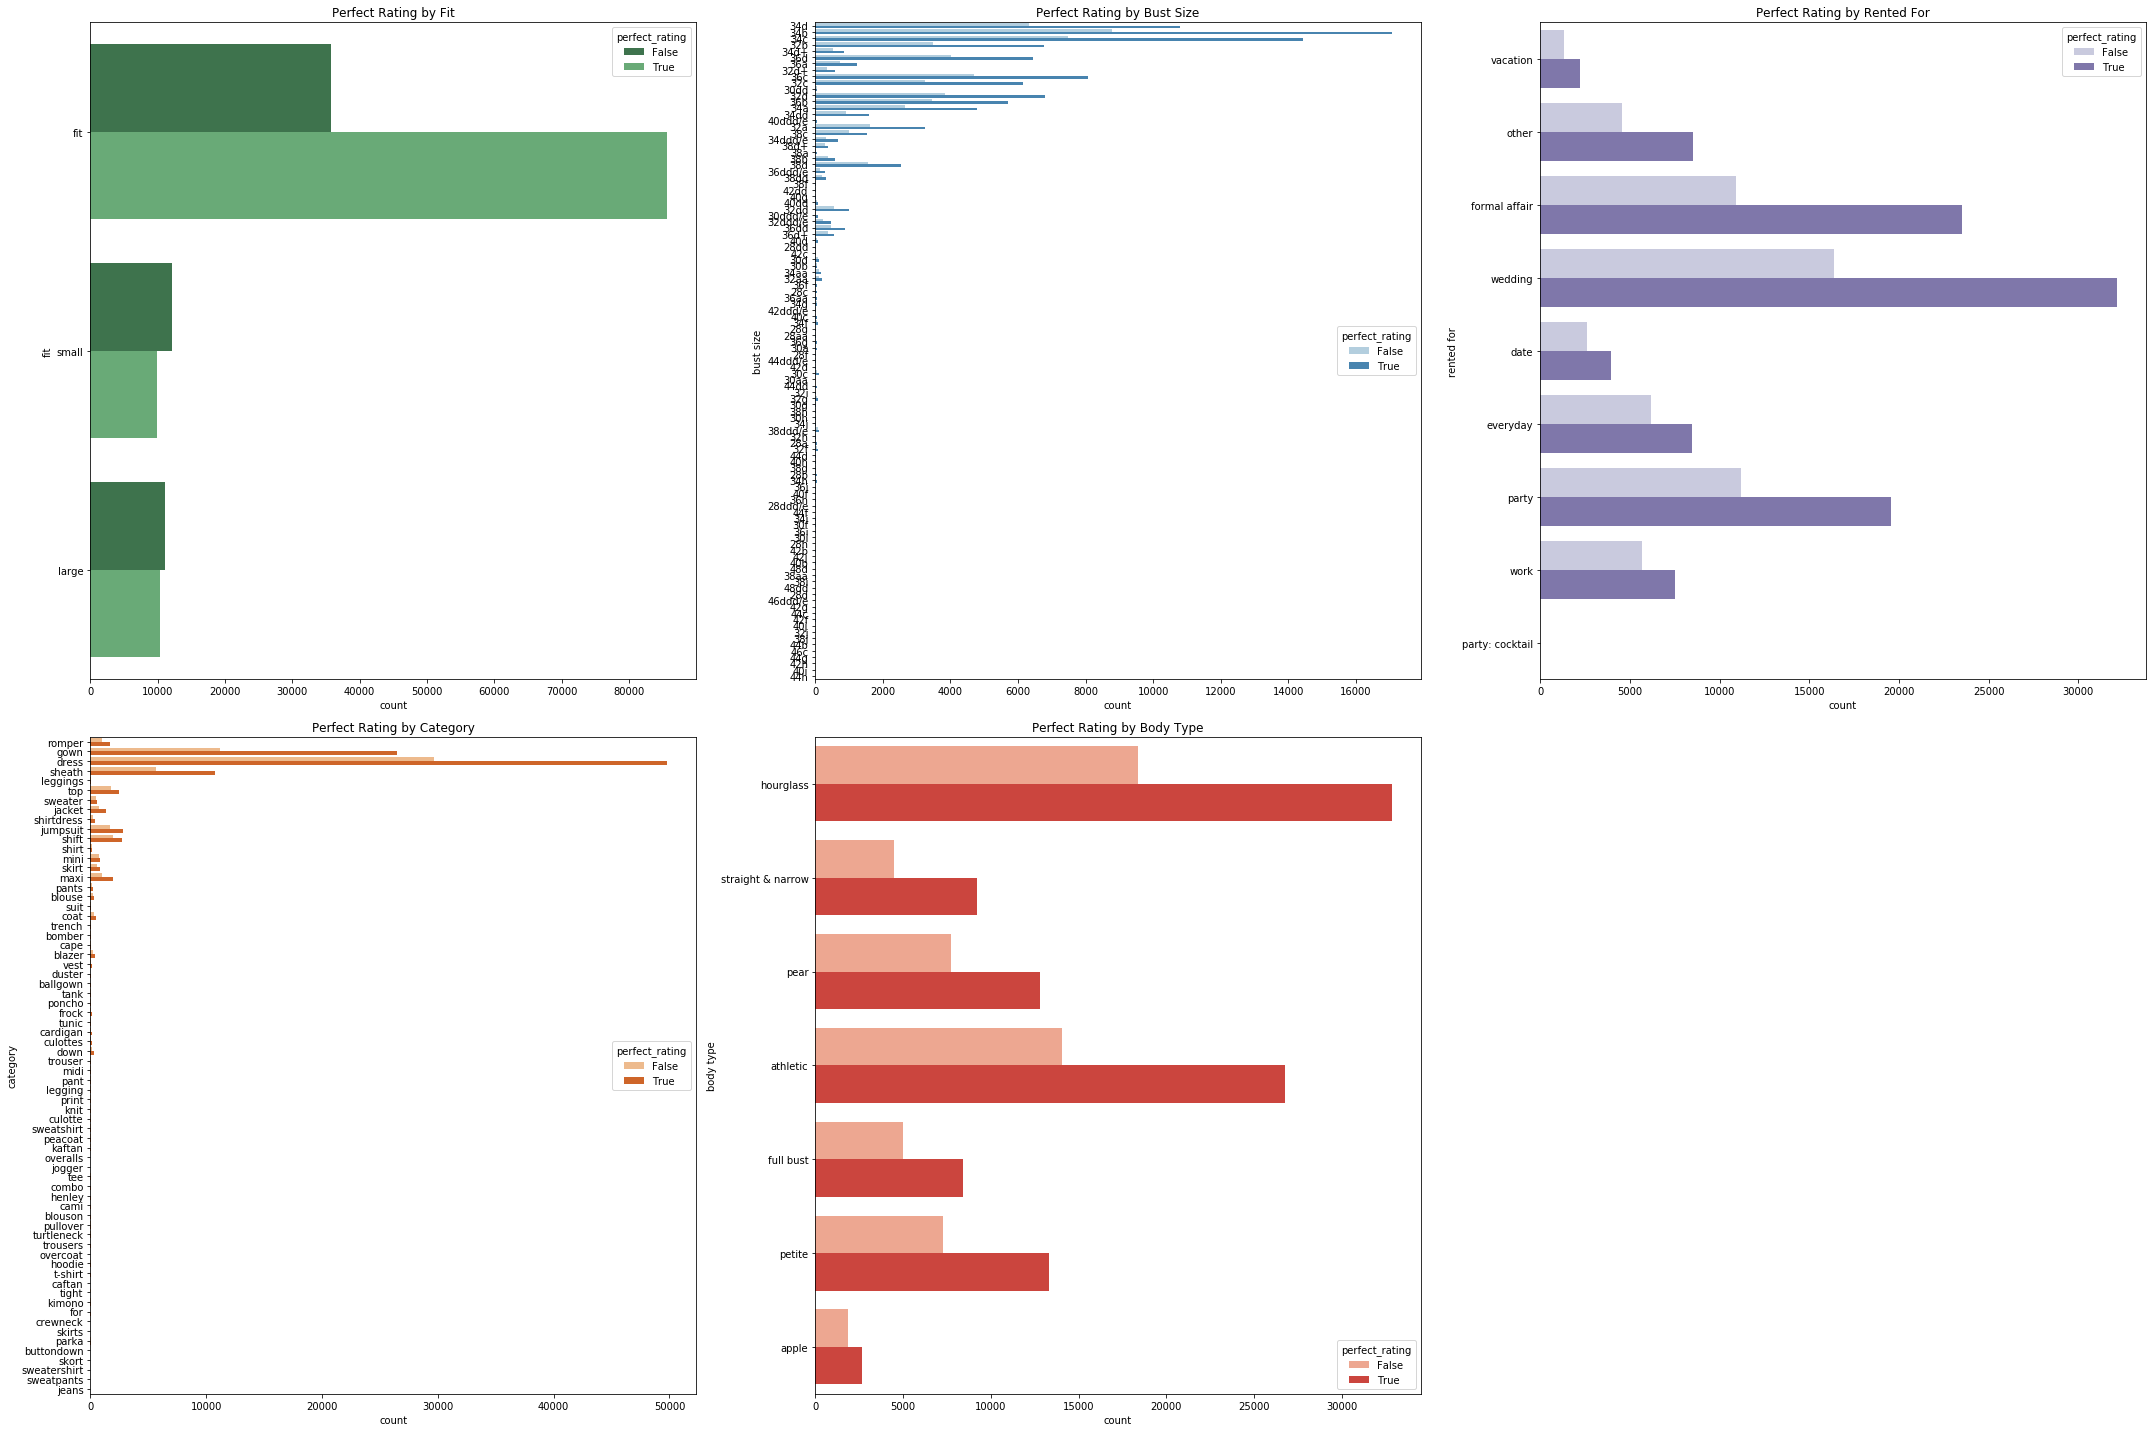

In [22]:
plt.figure(figsize = (30, 20))
plt.subplot(2, 3, 1)
sns.countplot(y='fit', hue='perfect_rating', data= rtr_df, palette='Greens_d')
plt.title('Perfect Rating by Fit')
plt.subplot(2, 3, 2)
sns.countplot(y='bust size', hue='perfect_rating', data= rtr_df, palette='Blues')
plt.title('Perfect Rating by Bust Size')
plt.subplot(2, 3, 3)
sns.countplot(y='rented for', hue='perfect_rating', data= rtr_df, palette='Purples')
plt.title('Perfect Rating by Rented For')
plt.subplot(2, 3, 4)
sns.countplot(y='category', hue='perfect_rating', data= rtr_df, palette='Oranges')
plt.title('Perfect Rating by Category')
plt.subplot(2, 3, 5)
sns.countplot(y='body type', hue='perfect_rating', data= rtr_df, palette='Reds')
plt.title('Perfect Rating by Body Type')
plt.tight_layout()
plt.show()

There are many categories of bust size and category, so if we want to use these variables, we may want to group some of the categories together. Fit most clearly shows a difference between items that recieve a perfect rating and items that do not

Now that the data is clean, I will test out a variety of different models and see whether I can classify items that recieve a perfect rating and items that do not. I will start with a Naive Bayes classifier using the review summary.

In [23]:
#select summary and perfect rating variables
reviews = rtr_df[['review_summary', 'perfect_rating']]
#define keywords for classifier
keywords = ['big', 'large', "wasn't", 'small', 'disappointed', 'not', 'matronly', 'beware', 'mixed feelings',
           'tight', "didn't", 'wrong', 'constricting', 'thin', 'too', 'funny', "wouldn't", 'frumpy', 'forgettable', 'short',
           'tricky', 'wrinkles', 'broke', 'wrinkled', 'ok', 'unflattering', 'hard', 'bulky', 'zipper', 'issues', 'odd',
           'size down', 'ironing', 'bizarre', 'but', 'heavy', 'difficult', 'horrible', 'boxy', 'didnt', 'weird', 'hole',
           'poor', 'itchy', 'shapeless', 'poofy', 'hips', 'never', 'kinda', 'snug', 'sack-like', 'flaws', 'pain']
for key in keywords:
    reviews[str(key)] = reviews.review_summary.str.contains(' ' + str(key) + ' '+'|'+ ' ' + str(key) + '.' 
                                                          +'|'+' ' + str(key) + '!'+'|'+ ' '+ str(key) + ','
                                                            '|' + str(key), case=False)

C:\Users\rkies\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


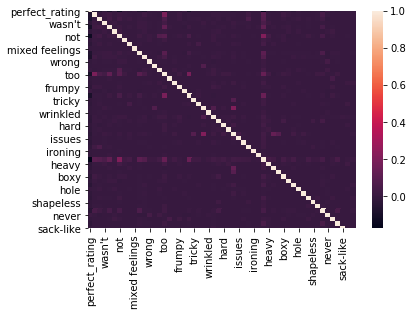

In [24]:
#show correlation between keywords
sns.heatmap(reviews.corr())
plt.show()

In [25]:
#define data and target
data = reviews[keywords]
target = reviews['perfect_rating']

In [26]:
#fit model
model = BernoulliNB()
model.fit(data, target)
prediction = model.predict(data)
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != prediction).sum()
))

Number of mislabeled points out of a total 164684 points : 50687


In [27]:
confusion_matrix(target, prediction)

array([[14858, 43888],
       [ 6799, 99139]], dtype=int64)

In [28]:
cross_val_score(model, data, target, cv=10)

array([0.69123808, 0.69366689, 0.6876556 , 0.69439553, 0.69510566,
       0.69255526, 0.69565217, 0.69079427, 0.69042992, 0.69024775])

The Naive Bayes classifier classified about 69% of reviews correctly, which is a little bit better than the baseline of 64%. The primary issue with this model is that it incorrectly classified reviews that were not rated 10.0. This is possibly because reviews of items rated 8.0 contained similar words to items rated 10.0. Next, I will try a nearest neighbors model to see if that works better. For this model I will use weight, height, size, and age. I am not including user ID or item ID because these values do not add much information as numbers.

In [29]:
#take z-scores of numeric variables and implement knn
X = pd.DataFrame({'weight': stats.zscore(rtr_df['weight']), 'height': stats.zscore(rtr_df['height']),
                 'size': stats.zscore(rtr_df['size']), 'age': stats.zscore(rtr_df['age'])})
Y = rtr_df['perfect_rating']

#knn with 1 nearest neighbor, unweighted
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, Y)

score = cross_val_score(knn, X, Y, cv=5, scoring = 'accuracy')
print('Accuracy of Unweighted KNN Model (1 neighbor): %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

Accuracy of Unweighted KNN Model (1 neighbor): 0.55 (+/- 0.01)


In [30]:
#knn with 10 neighbors, unweighted
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X, Y)

score = cross_val_score(knn, X, Y, cv=5, scoring = 'accuracy')
print('Accuracy of Unweighted KNN Model (10 neighbors): %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

Accuracy of Unweighted KNN Model (10 neighbors): 0.58 (+/- 0.00)


In [31]:
#knn with 10 neighbors, weighted
knn = KNeighborsClassifier(n_neighbors=10, weights = 'distance')
knn.fit(X, Y)

score = cross_val_score(knn, X, Y, cv=5, scoring = 'accuracy')
print('Accuracy of Weighted KNN Model (10 neighbors): %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

Accuracy of Weighted KNN Model (10 neighbors): 0.57 (+/- 0.00)


In [32]:
#knn with 100 neighbors, unweighted
knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(X, Y)

score = cross_val_score(knn, X, Y, cv=5, scoring = 'accuracy')
print('Accuracy of Unweighted KNN Model (100 neighbors): %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

Accuracy of Unweighted KNN Model (100 neighbors): 0.64 (+/- 0.00)


In [33]:
#knn with 100 neighbors, weighted
knn = KNeighborsClassifier(n_neighbors=100, weights = 'distance')
knn.fit(X, Y)

score = cross_val_score(knn, X, Y, cv=5, scoring = 'accuracy')
print('Accuracy of Weighted KNN Model: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

Accuracy of Weighted KNN Model: 0.60 (+/- 0.00)


In [34]:
#knn with 1000 neighbors, unweighted
knn = KNeighborsClassifier(n_neighbors=1000)
knn.fit(X, Y)

score = cross_val_score(knn, X, Y, cv=5, scoring = 'accuracy')
print('Accuracy of Unweighted KNN Model: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))

Accuracy of Unweighted KNN Model: 0.64 (+/- 0.00)


None of the K-Nearest Neighbors models performed better than assigning everything to one group. Next, I will try a decision tree. I will use the same features as in the K-Nearest Neighbors model (weight, height, size, and age).

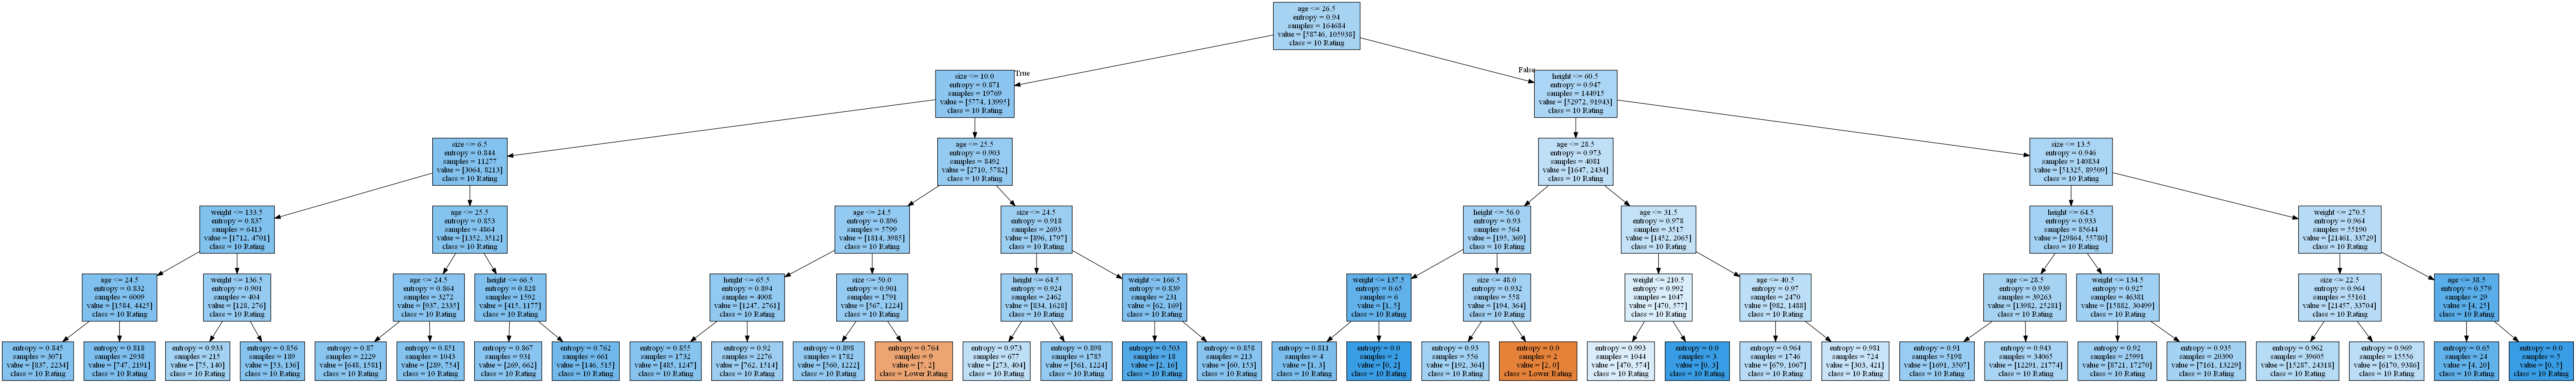

In [35]:
# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=5,
)

#drop non-numeric variables as well as rating and perfect rating
X = rtr_df.drop(['perfect_rating', 'rating', 'fit', 'bust size', 'rented for', 'review_text', 'body type', 
                 'review_summary', 'category', 'review_date', 'user_id', 'item_id'], 1)
Y = rtr_df['perfect_rating']
decision_tree.fit(X, Y)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names= ['weight', 'height', 'size', 'age'
                   ],
    class_names=['Lower Rating', '10 Rating'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('original_tree.png')

Image('original_tree.png')

In [36]:
#get accuracy of decision tree
y_pred = decision_tree.predict(X)
print('Accuracy:', accuracy_score(Y, y_pred))

Accuracy: 0.6433229700517354


The accuracy of the decision tree was similar to that of the best KNN models. Next, I will try a random forest.

In [37]:
#define random forest model
rfc = ensemble.RandomForestClassifier()
print(cross_val_score(rfc, X, Y, cv=5, scoring = 'accuracy'))

[0.5979901  0.59887057 0.60011537 0.59528797 0.60122662]


Next, I will try modifying the random forest model to include the user id and item id variables.

In [38]:
#add in user id and item id variables
X = rtr_df.drop(['perfect_rating', 'rating', 'fit', 'bust size', 'rented for', 'review_text', 'body type', 
                 'review_summary', 'category', 'review_date',], 1)
Y = rtr_df['perfect_rating']
rfc = ensemble.RandomForestClassifier()
print(cross_val_score(rfc, X, Y, cv=5, scoring = 'accuracy'))

[0.61918207 0.62331117 0.62370586 0.61793727 0.62241924]


Since the model that includes user id and item id performed similarly to the model that does not, I will not include those variables in future models. Now, I will try adding in some of the categorical variables into the model. I will create dummy variables for fit and rented for, and see whether including those variables improves model performance.

In [39]:
#get dummies for fit variable
rtr_df = pd.concat([rtr_df,pd.get_dummies(rtr_df['fit'], prefix='fit', drop_first=True)], axis=1)
fit_column_names = list(pd.get_dummies(rtr_df['fit'], prefix='fit', drop_first=True).columns)
#get dummies for rented for variable
rtr_df = pd.concat([rtr_df,pd.get_dummies(rtr_df['rented for'], prefix='for', drop_first=True)], axis=1)
for_column_names = list(pd.get_dummies(rtr_df['rented for'], prefix='for', drop_first=True).columns)

In [40]:
#include fit and rented for variables, drop user id and item id
X = rtr_df.drop(['perfect_rating', 'rating', 'fit', 'bust size', 'rented for', 'review_text', 'body type', 
                 'review_summary', 'category', 'review_date', 'user_id', 'item_id'], 1)
Y = rtr_df['perfect_rating']
rfc = ensemble.RandomForestClassifier()
print(cross_val_score(rfc, X, Y, cv=5, scoring = 'accuracy'))

[0.61778547 0.62136807 0.62191456 0.61887846 0.6209315 ]


This model performs better than the original random forest model. Now, I will try adding dummy variables for category. Since there are so many different categories, I will only include dummy variables for categories that included at least 500 rentals.

In [41]:
#get most common categories
category_counts = pd.DataFrame(rtr_df['category'].value_counts())
category_counts[category_counts['category'] >= 500]

,category
dress,79472
gown,37675
sheath,16456
shift,4622
jumpsuit,4434
top,4221
maxi,2964
romper,2689
jacket,2075
mini,1575


In [42]:
#create dummy variables for most common categories
top_categories = ['dress', 'gown', 'sheath', 'shift', 'jumpsuit', 'top', 'maxi', 'romper', 'jacket', 'mini', 'skirt', 
                  'sweater', 'coat', 'blazer', 'shirtdress', 'blouse']
category_columns = pd.get_dummies(rtr_df['category'], prefix = 'category')
category_column_names = []
for cat in top_categories:
    rtr_df = pd.concat([rtr_df, category_columns['category_' + cat]], axis=1)
    category_column_names.append('category_' + cat)

In [43]:
#include category variables in model
X = rtr_df.drop(['perfect_rating', 'rating', 'fit', 'bust size', 'rented for', 'review_text', 'body type', 
                 'review_summary', 'category', 'review_date', 'user_id', 'item_id',], 1)
Y = rtr_df['perfect_rating']
rfc = ensemble.RandomForestClassifier()
print(cross_val_score(rfc, X, Y, cv=5, scoring = 'accuracy'))

[0.62340225 0.62112518 0.62643835 0.62039651 0.62159947]


This model performs similarly to the previous model, so I will not include the category variables in the next model. I will now follow a similar process to create dummy variables for the most common bust sizes.

In [44]:
#get value counts for bust size
bust_size_counts = pd.DataFrame(rtr_df['bust size'].value_counts())
bust_size_counts[bust_size_counts['bust size'] >= 500]

,bust size
34b,25840
34c,21937
34d,17129
36c,12761
32d,10642
36d,10469
32b,10248
32c,9399
36b,9155
34a,7437


In [45]:
#create dummy variables for the most common bust sizes
top_bust_sizes = ['34b', '34c', '34d', '36c', '32d', '36d', '32b', '32c', '36b', '34a', '32a', '38d', '38c', '34dd', '36a',
                  '32dd', '34d+', '36dd', '34ddd/e', '38b', '36d+', '32d+', '32ddd/e', '38d+']
bust_size_columns = pd.get_dummies(rtr_df['bust size'], prefix = 'bust_size')
bust_size_column_names = []
for cat in top_bust_sizes:
    rtr_df = pd.concat([rtr_df, bust_size_columns['bust_size_' + cat]], axis=1)
    bust_size_column_names.append('bust_size_' + cat)

In [46]:
#include bust size variables
X = rtr_df.drop(['perfect_rating', 'rating', 'fit', 'bust size', 'rented for', 'review_text', 'body type', 
                 'review_summary', 'category', 'review_date', 'user_id', 'item_id'] + category_column_names, 1)
Y = rtr_df['perfect_rating']
rfc = ensemble.RandomForestClassifier()
print(cross_val_score(rfc, X, Y, cv=5, scoring = 'accuracy'))

[0.63226766 0.6292012  0.63466618 0.6297477  0.63277265]


The random forest model performs worse than just classifying everything as a single group. It is possible that this could be improved by incorporating more features, but first I will try support vector machines. Because of the number of samples in the dataset, a support vector classifier is unlikely to work within a reasonable amount of time. I will try two techniques to create a support vector classifier that takes a reasonable amount of time to run: subsampling and a linear support vector classifier. I will start with subsampling.

In [47]:
#take sample of 20,000 rows
sample_train = rtr_df.sample(n=20000, random_state=1)
#select X and Y using the same columns as last random forest model
X_sample = sample_train.drop(['perfect_rating', 'rating', 'fit', 'bust size', 'rented for', 'review_text', 'body type', 
                 'review_summary', 'category', 'review_date', 'user_id', 'item_id',] + category_column_names, 1)
Y_sample = sample_train['perfect_rating']
#define support vector classifier
svc = SVC()
#we will use the same variables as the random forest model
svc.fit(X_sample,Y_sample)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

[[    0  7072]
 [    0 12928]]


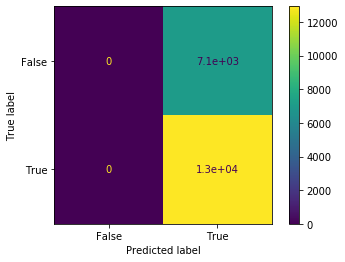

In [48]:
disp = plot_confusion_matrix(svc, X_sample, Y_sample)
print(disp.confusion_matrix)

plt.show()

In [49]:
#get performance of support vector classifier
svc.score(X_sample, Y_sample)

0.6464

Instead of running a cross validation for this model, we will take 5 samples of 10,000 rows each and see how the model performs on those.

In [50]:
for i in range(0, 5):
    sample_i = rtr_df.sample(n = 10000)
    X_samplei = sample_i.drop(['perfect_rating', 'rating', 'fit', 'bust size', 'rented for', 'review_text', 'body type', 
                 'review_summary', 'category', 'review_date', 'user_id', 'item_id',] + category_column_names, 1)
    Y_samplei = sample_i['perfect_rating']
    print('Sample ' + str(i) + ' score: ', svc.score(X_samplei, Y_samplei))

Sample 0 score:  0.6468
Sample 1 score:  0.6443
Sample 2 score:  0.6431
Sample 3 score:  0.6462
Sample 4 score:  0.648


Depending on the sample, the model classifies everthing as a perfectly rated rental. Now, I will try a linear support vector classifier with the full dataset

In [51]:
#define linear svc
linear_svc = LinearSVC()
#we will use the same variables as the random forest model
linear_svc.fit(X,Y)

C:\Users\rkies\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

[[     0  58746]
 [     0 105938]]


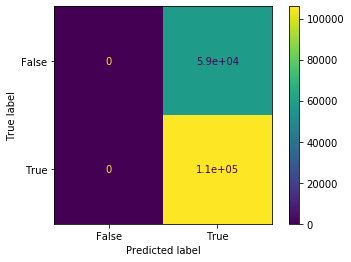

In [52]:
disp = plot_confusion_matrix(linear_svc, X, Y)
print(disp.confusion_matrix)

plt.show()

In [53]:
linear_svc.score(X, Y)

0.6432804644045566

In [54]:
print(cross_val_score(linear_svc, X, Y, cv=5, scoring = 'accuracy'))

C:\Users\rkies\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rkies\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rkies\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\rkies\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[0.64341015 0.6432887  0.6432887  0.35674166 0.35672213]


C:\Users\rkies\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


This model performs extremely poorly.

Overall, the model that performed the best was the Naive Bayes classifier using the review text. This indicates that using more advanced natural language processing techniques could be helpful in modeling this data. Additionally, if Rent the Runway wanted to further study this data, they might want to add new variables such as the price, color or brand of the item rented.